# Final Evaluation on Testing Set

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Model packages
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from time import time
import pprint
import joblib
from functools import partial

from sklearn.model_selection import KFold, StratifiedKFold
# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score


# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

import pickle

#display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

path = '/home/jln436/Internship_AUMC/'

## Load the data

In [2]:
random_seed = 42

In [3]:
# Load testing sets
df = pd.read_csv(path + 'output/dfs/X_test_final.csv')
target = pd.read_csv(path + 'output/dfs/y_test_final.csv')
# Get df_train for scaling the testing dataset
df_train = pd.read_csv(path + 'output/dfs/X_train_final.csv')
y_train = pd.read_csv(path + 'output/dfs/y_train_final.csv')
# Get no cognitive function datasets
df_train_nc = pd.read_csv(path + 'output/dfs/X_train_final_minus.csv')
df_nc = pd.read_csv(path + 'output/dfs/X_test_final_minus.csv')

In [4]:
# Remove id number because not useful for predictions
df.drop(columns = ['respnr'], inplace = True)
df_train.drop(columns = ['respnr'], inplace = True)
df_nc.drop(columns = ['respnr'], inplace = True)
df_train_nc.drop(columns = ['respnr'], inplace = True)

In [5]:
#Scale features
scaler = StandardScaler()
scaler.fit(df_train)
df_train = pd.DataFrame(scaler.transform(df_train), columns = df_train.columns)
df = pd.DataFrame(scaler.transform(df), columns = df.columns)
#Scale features
scaler2 = StandardScaler()
scaler2.fit(df_train_nc)
df_train_nc = pd.DataFrame(scaler2.transform(df_train_nc), columns = df_train_nc.columns)
df_nc = pd.DataFrame(scaler2.transform(df_nc), columns = df_nc.columns)

## Load the models

In [6]:
lgbm_model_full = pickle.load(open(path + '/output/models/lightGBM_bayesian_training_model.sav', 'rb'))
rf_model_full = pickle.load(open(path + '/output/models/RF_bayesian_training_model.sav', 'rb'))
lasso_model_full = pickle.load(open(path + '/output/models/Lasso_bayesian_training_model.sav', 'rb'))
ridge_model_full = pickle.load(open(path + '/output/models/Ridge_bayesian_training_model.sav', 'rb'))
svm_model_full = pickle.load(open(path + '/output/models/SVM_bayesian_training_model.sav', 'rb'))

lgbm_model_nc = pickle.load(open(path + '/output/models/lightGBM_bayesian_training_model_no_cog_tests.sav', 'rb'))
rf_model_nc = pickle.load(open(path + '/output/models/RF_bayesian_training_model_no_cog_tests.sav', 'rb'))
lasso_model_nc = pickle.load(open(path + '/output/models/Lasso_bayesian_training_model_no_cog_tests.sav', 'rb'))
ridge_model_nc = pickle.load(open(path + '/output/models/Ridge_bayesian_training_model_no_cog_tests.sav', 'rb'))
svm_model_nc = pickle.load(open(path + '/output/models/SVM_bayesian_training_model_no_cog_tests.sav', 'rb'))

## Train models on full training data

#### Light GBM

In [7]:
lgbm_model_full = lgb.LGBMRegressor(**lgbm_model_full.get_params())
lgbm_model_full.fit(df_train, y_train)
# Make predictions:
y_pred_lgbm_full = lgbm_model_full.predict(df)

[LightGBM] [Warning] feature_fraction is set=0.22186280898586927, colsample_bytree=0.10380922914376393 will be ignored. Current value: feature_fraction=0.22186280898586927
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


In [8]:
# accuracy check
mse = mean_squared_error(target, y_pred_lgbm_full)
rmse = mse**(0.5)
mae = mean_absolute_error(target, y_pred_lgbm_full)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MAE: 2.67
MSE: 11.08
RMSE: 3.33


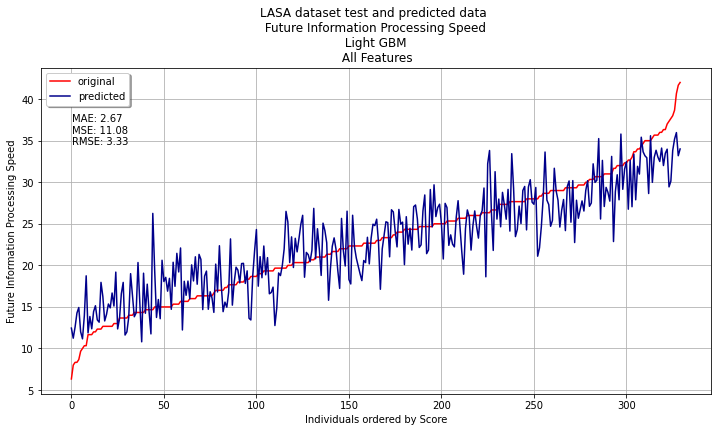

In [10]:
lgbm_full_df = pd.DataFrame(data = target, columns = ['target'])
lgbm_full_df['predicted'] = y_pred_lgbm_full
lgbm_full_df = lgbm_full_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, lgbm_full_df.target, label="original", color = "red")
plt.plot(x_ax, lgbm_full_df.predicted, label="predicted", color = "darkblue")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Light GBM \n All Features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 34.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)), fontsize = 10)
plt.show()

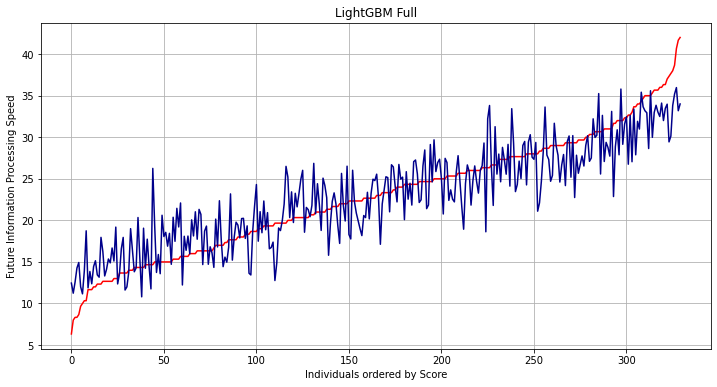

In [11]:
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, lgbm_full_df.target, label="original", color = "red")
plt.plot(x_ax, lgbm_full_df.predicted, label="predicted", color = "darkblue")
plt.title("LightGBM Full")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.grid(True)
plt.savefig(path + '/output/plots/lgbm_full.png')

In [12]:
lgbm_model_nc = lgb.LGBMRegressor(**lgbm_model_nc.get_params())
lgbm_model_nc.fit(df_train_nc, y_train)
# Make predictions:
y_pred_lgbm_nc = lgbm_model_nc.predict(df_nc)

[LightGBM] [Warning] feature_fraction is set=0.8620157098018509, colsample_bytree=0.5921515952229944 will be ignored. Current value: feature_fraction=0.8620157098018509
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


In [13]:
# accuracy check
mse = mean_squared_error(target, y_pred_lgbm_nc)
rmse = mse**(0.5)
mae = mean_absolute_error(target, y_pred_lgbm_nc)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MAE: 4.34
MSE: 29.96
RMSE: 5.47


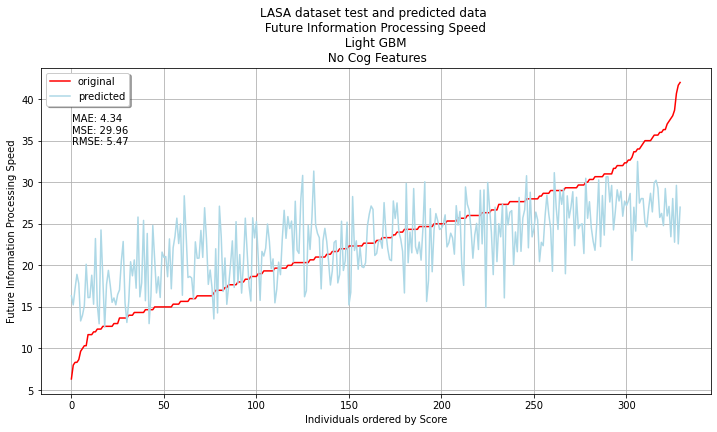

In [14]:
lgbm_nc_df = pd.DataFrame(data = target, columns = ['target'])
lgbm_nc_df['predicted'] = y_pred_lgbm_nc
lgbm_nc_df = lgbm_nc_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, lgbm_nc_df.target, label="original", color = "red")
plt.plot(x_ax, lgbm_nc_df.predicted, label="predicted", color = "lightblue")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Light GBM \n No Cog Features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 34.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)), fontsize = 10)
plt.show()

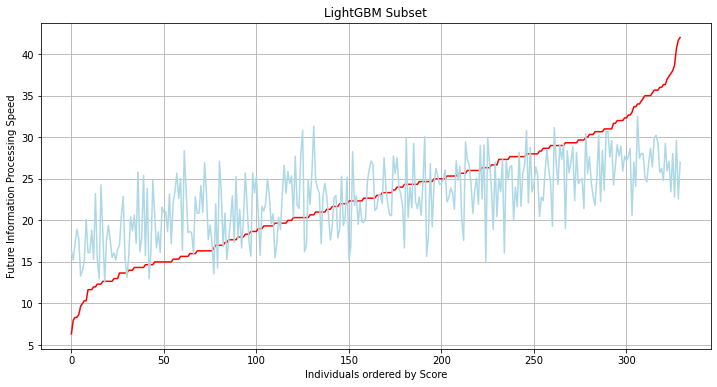

In [15]:
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, lgbm_nc_df.target, label="original", color = "red")
plt.plot(x_ax, lgbm_nc_df.predicted, label="predicted", color = "lightblue")
plt.title("LightGBM Subset")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.grid(True)
plt.savefig(path + '/output/plots/lgbm_subset.png')

#### Random Forest

In [16]:
# Make predictions on the testing data set:
rf_model_full = RandomForestRegressor(**rf_model_full.get_params())
rf_model_full.fit(df_train, y_train)
# Make predictions:
y_pred_rf_full = rf_model_full.predict(df)

In [17]:
# accuracy check
mse = mean_squared_error(target, y_pred_rf_full)
rmse = mse**(0.5)
mae = mean_absolute_error(target, y_pred_rf_full)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MAE: 2.54
MSE: 10.24
RMSE: 3.20


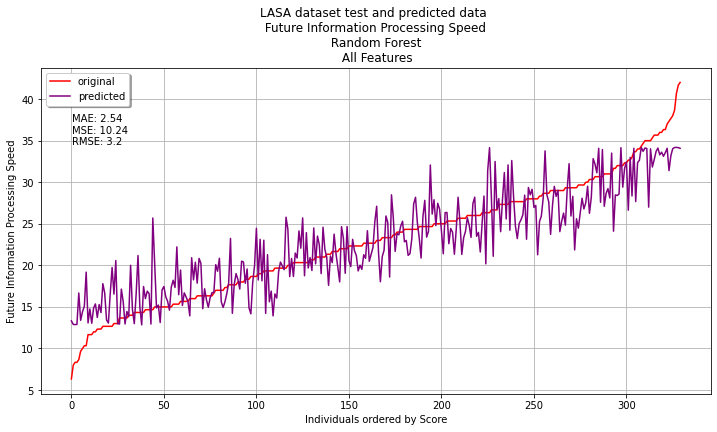

In [18]:
rf_full_df = pd.DataFrame(data = target, columns = ['target'])
rf_full_df['predicted'] = y_pred_rf_full
rf_full_df = rf_full_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, rf_full_df.target, label="original", color = "red")
plt.plot(x_ax, rf_full_df.predicted, label="predicted", color = "purple")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Random Forest \n All Features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 34.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)), fontsize = 10)
plt.show()

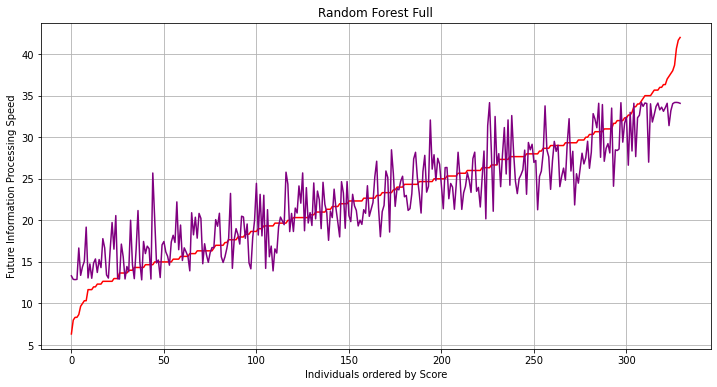

In [19]:
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, rf_full_df.target, label="original", color = "red")
plt.plot(x_ax, rf_full_df.predicted, label="predicted", color = "purple")
plt.title("Random Forest Full")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.grid(True)
plt.savefig(path + '/output/plots/rf_full.png')

In [20]:
rf_model_nc = RandomForestRegressor(**rf_model_nc.get_params())
rf_model_nc.fit(df_train_nc, y_train)
# Make predictions:
y_pred_rf_nc = rf_model_nc.predict(df_nc)

In [21]:
# accuracy check
mse = mean_squared_error(target, y_pred_rf_nc)
rmse = mse**(0.5)
mae = mean_absolute_error(target, y_pred_rf_nc)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MAE: 4.51
MSE: 31.61
RMSE: 5.62


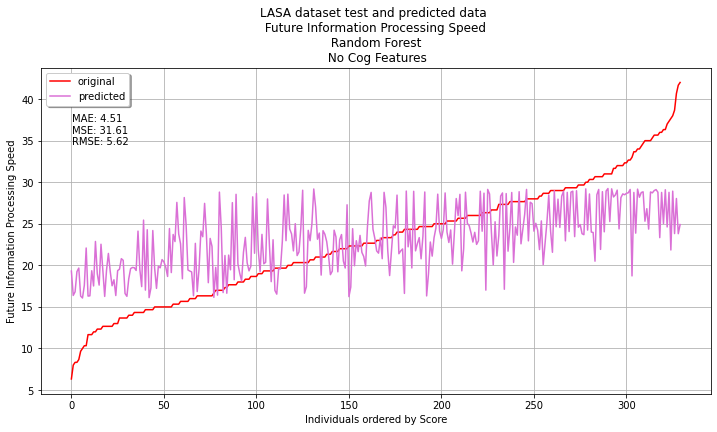

In [22]:
rf_nc_df = pd.DataFrame(data = target, columns = ['target'])
rf_nc_df['predicted'] = y_pred_rf_nc
rf_nc_df = rf_nc_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, rf_nc_df.target, label="original", color = "red")
plt.plot(x_ax, rf_nc_df.predicted, label="predicted", color = "orchid")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Random Forest \n No Cog Features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 34.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)), fontsize = 10)
plt.show()

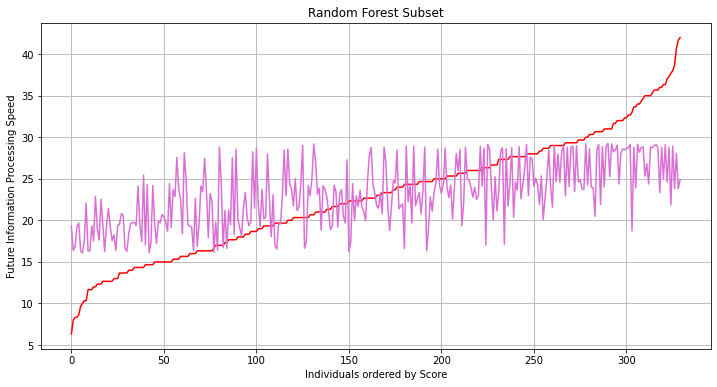

In [23]:
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, rf_nc_df.target, label="original", color = "red")
plt.plot(x_ax, rf_nc_df.predicted, label="predicted", color = "orchid")
plt.title("Random Forest Subset")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.grid(True)
plt.savefig(path + '/output/plots/rf_subset.png')

#### Lasso Regression

In [24]:
# Make predictions on the testing data set:
lasso_model_full = Lasso(**lasso_model_full.get_params())
lasso_model_full.fit(df_train, y_train)
# Make predictions:
y_pred_lasso_full = lasso_model_full.predict(df)

In [25]:
# accuracy check
mse = mean_squared_error(target, y_pred_lasso_full)
rmse = mse**(0.5)
mae = mean_absolute_error(target, y_pred_lasso_full)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MAE: 2.51
MSE: 9.89
RMSE: 3.14


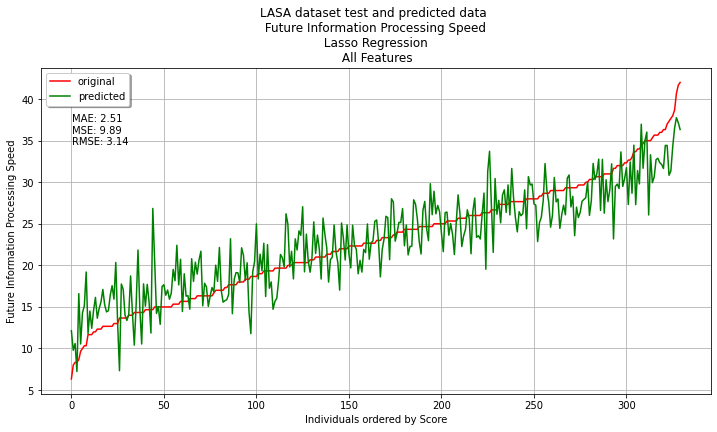

In [26]:
lasso_full_df = pd.DataFrame(data = target, columns = ['target'])
lasso_full_df['predicted'] = y_pred_lasso_full
lasso_full_df = lasso_full_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, lasso_full_df.target, label="original", color = "red")
plt.plot(x_ax, lasso_full_df.predicted, label="predicted", color = "green")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Lasso Regression \n All Features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 34.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)), fontsize = 10)
plt.show()

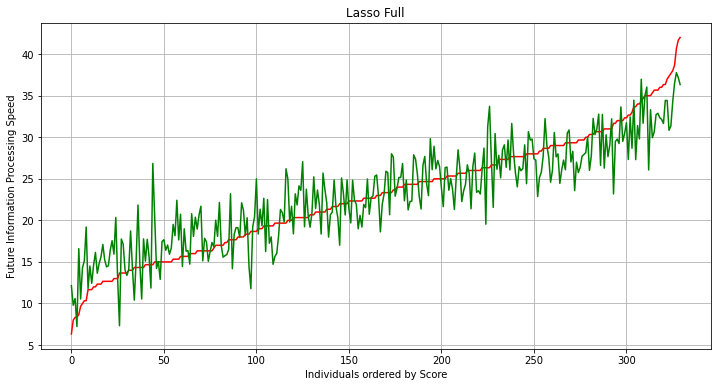

In [27]:
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, lasso_full_df.target, label="original", color = "red")
plt.plot(x_ax, lasso_full_df.predicted, label="predicted", color = "green")
plt.title("Lasso Full")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.grid(True)
plt.savefig(path + '/output/plots/lasso_full.png')

In [28]:
lasso_model_nc = Lasso(**lasso_model_nc.get_params())
lasso_model_nc.fit(df_train_nc, y_train)
# Make predictions:
y_pred_lasso_nc = lasso_model_nc.predict(df_nc)

In [29]:
# accuracy check
mse = mean_squared_error(target, y_pred_lasso_nc)
rmse = mse**(0.5)
mae = mean_absolute_error(target, y_pred_lasso_nc)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MAE: 4.45
MSE: 31.22
RMSE: 5.59


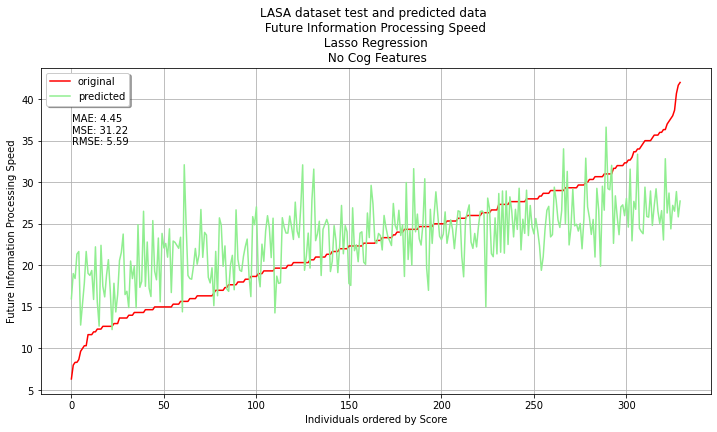

In [30]:
lasso_nc_df = pd.DataFrame(data = target, columns = ['target'])
lasso_nc_df['predicted'] = y_pred_lasso_nc
lasso_nc_df = lasso_nc_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, lasso_nc_df.target, label="original", color = "red")
plt.plot(x_ax, lasso_nc_df.predicted, label="predicted", color = "lightgreen")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Lasso Regression \n No Cog Features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 34.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)), fontsize = 10)
plt.show()

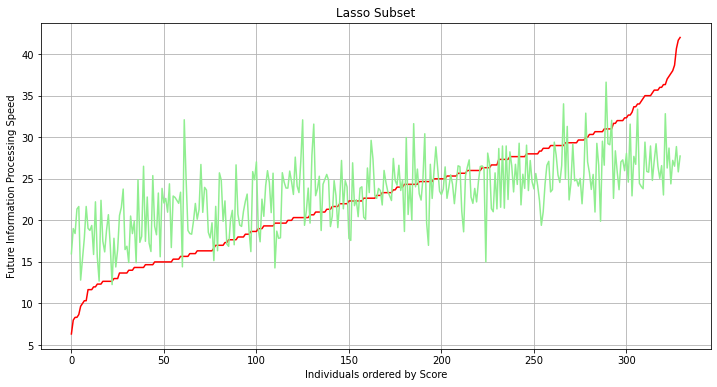

In [31]:
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, lasso_nc_df.target, label="original", color = "red")
plt.plot(x_ax, lasso_nc_df.predicted, label="predicted", color = "lightgreen")
plt.title("Lasso Subset")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.grid(True)
plt.savefig(path + '/output/plots/lasso_subset.png')

#### Ridge Regression

In [32]:
# Make predictions on the testing data set:
ridge_model_full = Ridge(**ridge_model_full.get_params())
ridge_model_full.fit(df_train, y_train)
# Make predictions:
y_pred_ridge_full = ridge_model_full.predict(df)

In [33]:
# accuracy check
mse = mean_squared_error(target, y_pred_ridge_full)
rmse = mse**(0.5)
mae = mean_absolute_error(target, y_pred_ridge_full)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MAE: 2.94
MSE: 13.39
RMSE: 3.66


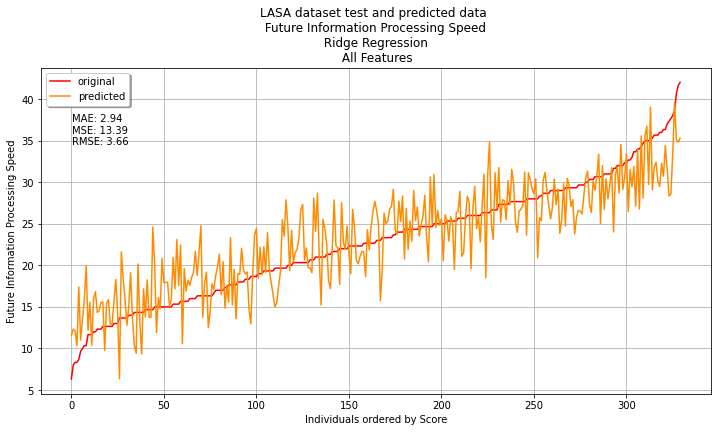

In [34]:
ridge_full_df = pd.DataFrame(data = target, columns = ['target'])
ridge_full_df['predicted'] = y_pred_ridge_full
ridge_full_df = ridge_full_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, ridge_full_df.target, label="original", color = "red")
plt.plot(x_ax, ridge_full_df.predicted, label="predicted", color = "darkorange")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Ridge Regression \n All Features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 34.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)), fontsize = 10)
plt.show()

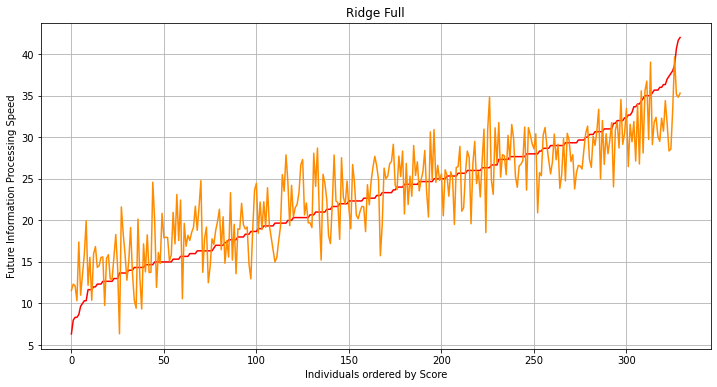

In [35]:
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, ridge_full_df.target, label="original", color = "red")
plt.plot(x_ax, ridge_full_df.predicted, label="predicted", color = "darkorange")
plt.title("Ridge Full")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.grid(True)
plt.savefig(path + '/output/plots/ridge_full.png')

In [36]:
ridge_model_nc = Ridge(**ridge_model_nc.get_params())
ridge_model_nc.fit(df_train_nc, y_train)
# Make predictions:
y_pred_ridge_nc = ridge_model_nc.predict(df_nc)

In [37]:
# accuracy check
mse = mean_squared_error(target, y_pred_ridge_nc)
rmse = mse**(0.5)
mae = mean_absolute_error(target, y_pred_ridge_nc)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MAE: 4.70
MSE: 35.32
RMSE: 5.94


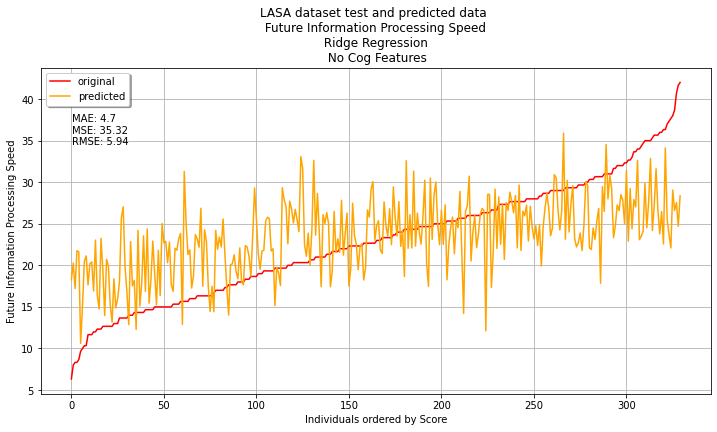

In [38]:
ridge_nc_df = pd.DataFrame(data = target, columns = ['target'])
ridge_nc_df['predicted'] = y_pred_ridge_nc
ridge_nc_df = ridge_nc_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, ridge_nc_df.target, label="original", color = "red")
plt.plot(x_ax, ridge_nc_df.predicted, label="predicted", color = "orange")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Ridge Regression \n No Cog Features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 34.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)), fontsize = 10)
plt.show()

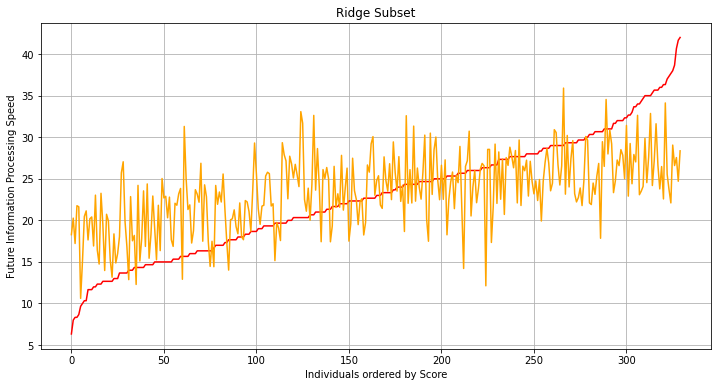

In [39]:
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, ridge_nc_df.target, label="original", color = "red")
plt.plot(x_ax, ridge_nc_df.predicted, label="predicted", color = "orange")
plt.title("Ridge Subset")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.grid(True)
plt.savefig(path + '/output/plots/ridge_subset.png')

#### SVM

In [40]:
# Make predictions on the testing data set:
svm_model_full = SVR(**svm_model_full.get_params())
svm_model_full.fit(df_train, y_train)
# Make predictions:
y_pred_svm_full = svm_model_full.predict(df)

In [41]:
# accuracy check
mse = mean_squared_error(target, y_pred_svm_full)
rmse = mse**(0.5)
mae = mean_absolute_error(target, y_pred_svm_full)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MAE: 3.14
MSE: 14.76
RMSE: 3.84


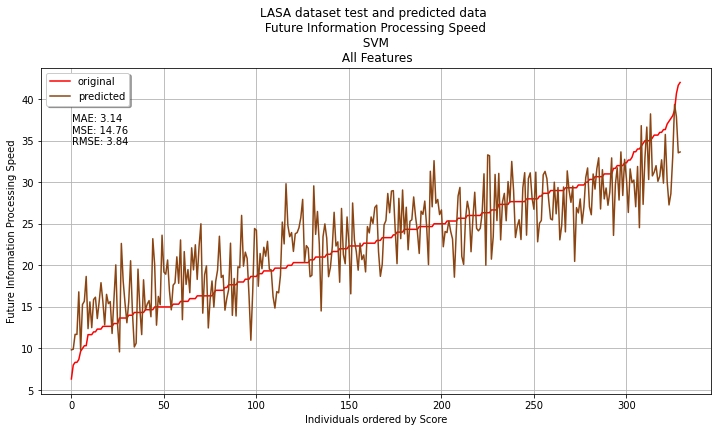

In [42]:
svm_full_df = pd.DataFrame(data = target, columns = ['target'])
svm_full_df['predicted'] = y_pred_svm_full
svm_full_df = svm_full_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, svm_full_df.target, label="original", color = "red")
plt.plot(x_ax, svm_full_df.predicted, label="predicted", color = "saddlebrown")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n SVM \n All Features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 34.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)), fontsize = 10)
plt.show()

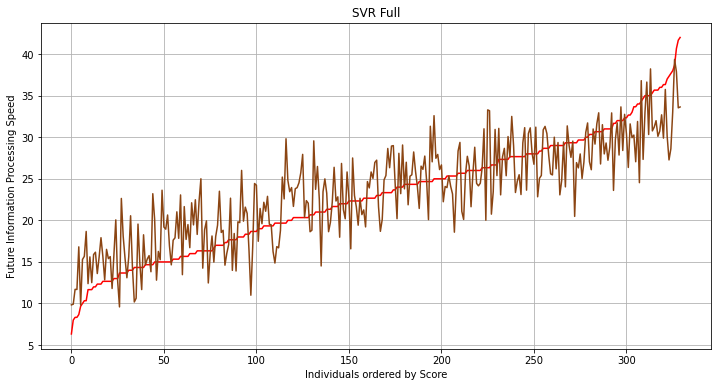

In [43]:
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, svm_full_df.target, label="original", color = "red")
plt.plot(x_ax, svm_full_df.predicted, label="predicted", color = "saddlebrown")
plt.title("SVR Full")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.grid(True)
plt.savefig(path + '/output/plots/svr_full.png')

In [44]:
svm_model_nc = SVR(**svm_model_nc.get_params())
svm_model_nc.fit(df_train_nc, y_train)
# Make predictions:
y_pred_svm_nc = svm_model_nc.predict(df_nc)

In [45]:
# accuracy check
mse = mean_squared_error(target, y_pred_svm_nc)
rmse = mse**(0.5)
mae = mean_absolute_error(target, y_pred_svm_nc)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MAE: 4.89
MSE: 36.93
RMSE: 6.08


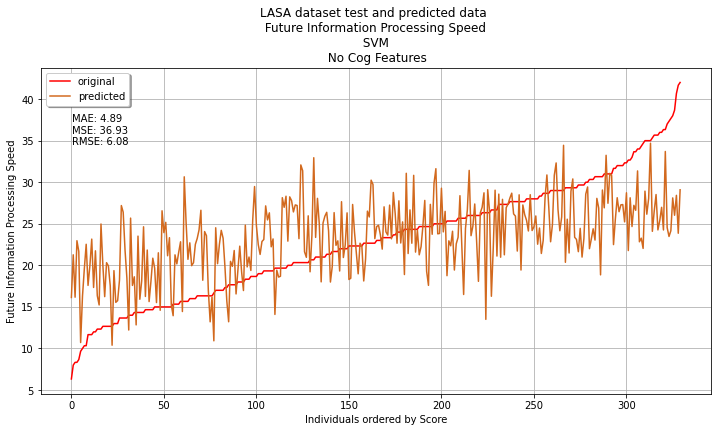

In [46]:
svm_nc_df = pd.DataFrame(data = target, columns = ['target'])
svm_nc_df['predicted'] = y_pred_svm_nc
svm_nc_df = svm_nc_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, svm_nc_df.target, label="original", color = "red")
plt.plot(x_ax, svm_nc_df.predicted, label="predicted", color = "chocolate")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n SVM \n No Cog Features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 34.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)), fontsize = 10)
plt.show()

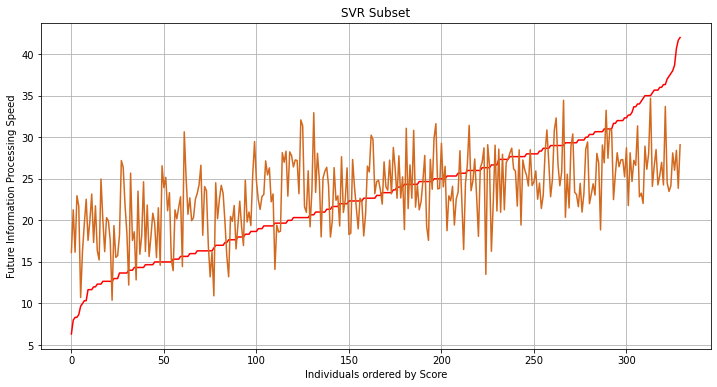

In [48]:
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, svm_nc_df.target, label="original", color = "red")
plt.plot(x_ax, svm_nc_df.predicted, label="predicted", color = "chocolate")
plt.title("SVR Subset")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.grid(True)
plt.savefig(path + '/output/plots/svr_subset.png')

## Explained Variance

In [40]:
# Load Features
lgbm_importance = pd.read_csv(path + "output/Importances/LightGBM_Importances_gain.csv")
rf_importance = pd.read_csv(path + "output/Importances/RF_Importances.csv")
Lasso_importance = pd.read_csv(path + "output/Importances/Lasso_Importances.csv")
Ridge_importance = pd.read_csv(path + "output/Importances/Ridge_Importances.csv")
SVM_importance = pd.read_csv(path + "output/Importances/SVM_Importances.csv")

lgbm_importance_nc = pd.read_csv(path + "output/Importances/LightGBM_Importances_gain_no_cog_tests.csv")
rf_importance_nc = pd.read_csv(path + "output/Importances/RF_Importances_no_cog_tests.csv")
Lasso_importance_nc = pd.read_csv(path + "output/Importances/Lasso_Importances_no_cog_tests.csv")
Ridge_importance_nc = pd.read_csv(path + "output/Importances/Ridge_Importances_no_cog_tests.csv")
SVM_importance_nc = pd.read_csv(path + "output/Importances/SVM_Importances_no_cog_tests.csv")

In [41]:
all_features_n = 49
ncog_features_n = 91

#### Light GBM

In [42]:
lm_lgbm_full = LinearRegression()
lm_lgbm_full.fit(df_train[lgbm_importance.features[0:all_features_n]], y_train)   
lm_pred_lgbm = lm_lgbm_full.predict(df[lgbm_importance.features[0:all_features_n]])

In [43]:
# accuracy check
mse = mean_squared_error(target, lm_pred_lgbm)
rmse = mse**(0.5)
mae = mean_absolute_error(target, lm_pred_lgbm)
score = r2_score(target, lm_pred_lgbm)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R^2: %.2f" % score)

MAE: 2.60
MSE: 10.56
RMSE: 3.25
R^2: 0.79


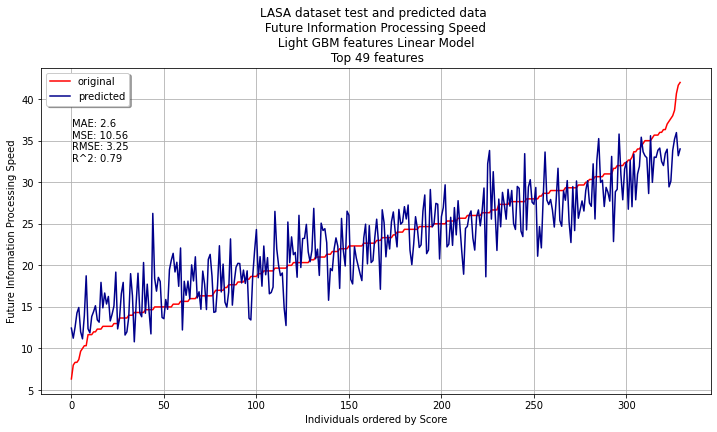

In [44]:
lgbm_full_df_lm = pd.DataFrame(data = target, columns = ['target'])
lgbm_full_df_lm['predicted'] = lm_pred_lgbm
lgbm_full_df = lgbm_full_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, lgbm_full_df.target, label="original", color = "red")
plt.plot(x_ax, lgbm_full_df.predicted, label="predicted", color = "darkblue")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Light GBM features Linear Model \n Top 49 features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 32.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)) + '\nR^2: ' + str(round(score,2)), fontsize = 10)
plt.show()

In [45]:
lm_lgbm_nc = LinearRegression()
lm_lgbm_nc.fit(df_train_nc[lgbm_importance_nc.features[0:ncog_features_n]], y_train)   
lm_pred_lgbm_nc = lm_lgbm_nc.predict(df_nc[lgbm_importance_nc.features[0:ncog_features_n]])

In [46]:
# accuracy check
mse = mean_squared_error(target, lm_pred_lgbm_nc)
rmse = mse**(0.5)
mae = mean_absolute_error(target, lm_pred_lgbm_nc)
score = r2_score(target, lm_pred_lgbm_nc)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R^2: %.2f" % score)

MAE: 4.65
MSE: 34.25
RMSE: 5.85
R^2: 0.30


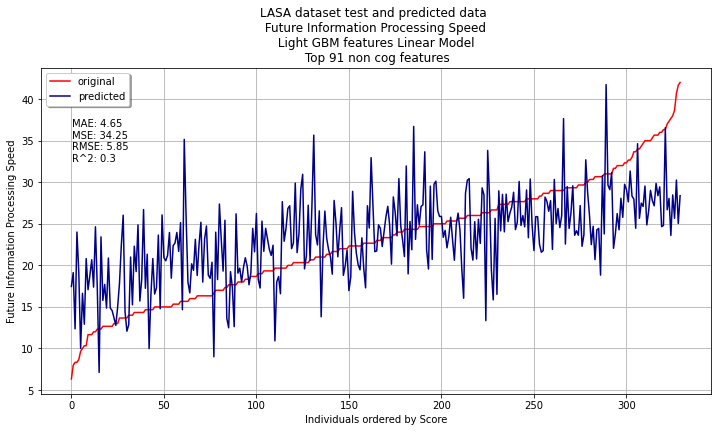

In [47]:
lgbm_nc_df_lm = pd.DataFrame(data = target, columns = ['target'])
lgbm_nc_df_lm['predicted'] = lm_pred_lgbm_nc
lgbm_nc_df_lm = lgbm_nc_df_lm.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, lgbm_nc_df_lm.target, label="original", color = "red")
plt.plot(x_ax, lgbm_nc_df_lm.predicted, label="predicted", color = "darkblue")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Light GBM features Linear Model \n Top 91 non cog features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 32.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)) + '\nR^2: ' + str(round(score,2)), fontsize = 10)
plt.show()

#### Random Forest

In [48]:
lm_rf_full = LinearRegression()
lm_rf_full.fit(df_train[rf_importance.features[0:all_features_n]], y_train)   
lm_pred_rf = lm_rf_full.predict(df[rf_importance.features[0:all_features_n]])

In [49]:
# accuracy check
mse = mean_squared_error(target, lm_pred_rf)
rmse = mse**(0.5)
mae = mean_absolute_error(target, lm_pred_rf)
score = r2_score(target, lm_pred_rf)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R^2: %.2f" % score)

MAE: 2.65
MSE: 10.71
RMSE: 3.27
R^2: 0.78


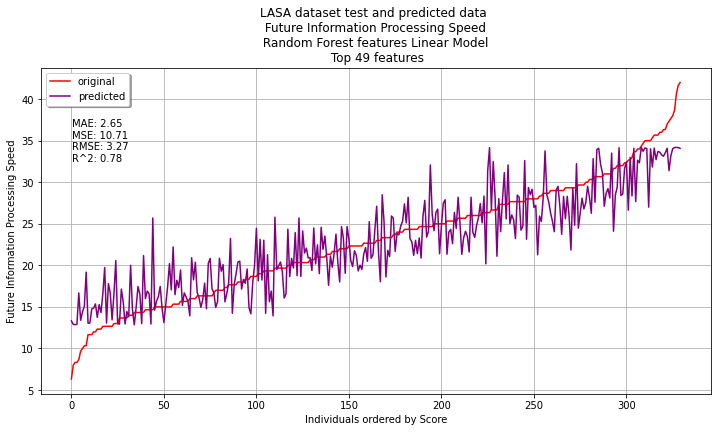

In [50]:
rf_full_df_lm = pd.DataFrame(data = target, columns = ['target'])
rf_full_df_lm['predicted'] = lm_pred_rf
rf_full_df = rf_full_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, rf_full_df.target, label="original", color = "red")
plt.plot(x_ax, rf_full_df.predicted, label="predicted", color = "purple")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Random Forest features Linear Model \n Top 49 features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 32.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)) + '\nR^2: ' + str(round(score,2)), fontsize = 10)
plt.show()

In [51]:
lm_rf_nc = LinearRegression()
lm_rf_nc.fit(df_train_nc[rf_importance_nc.features[0:ncog_features_n]], y_train)   
lm_pred_rf_nc = lm_rf_nc.predict(df_nc[rf_importance_nc.features[0:ncog_features_n]])

In [52]:
# accuracy check
mse = mean_squared_error(target, lm_pred_rf_nc)
rmse = mse**(0.5)
mae = mean_absolute_error(target, lm_pred_rf_nc)
score = r2_score(target, lm_pred_rf_nc)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R^2: %.2f" % score)

MAE: 4.76
MSE: 36.28
RMSE: 6.02
R^2: 0.26


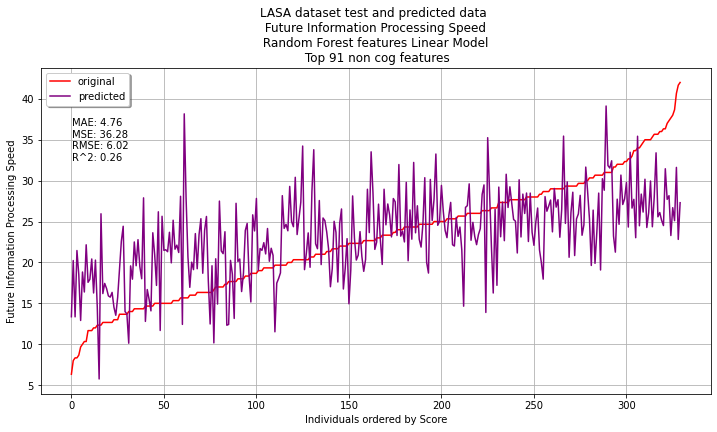

In [53]:
rf_nc_df_lm = pd.DataFrame(data = target, columns = ['target'])
rf_nc_df_lm['predicted'] = lm_pred_rf_nc
rf_nc_df_lm = rf_nc_df_lm.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, rf_nc_df_lm.target, label="original", color = "red")
plt.plot(x_ax, rf_nc_df_lm.predicted, label="predicted", color = "purple")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Random Forest features Linear Model \n Top 91 non cog features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 32.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)) + '\nR^2: ' + str(round(score,2)), fontsize = 10)
plt.show()

#### Lasso Regression

In [54]:
lm_lasso_full = LinearRegression()
lm_lasso_full.fit(df_train[Lasso_importance.features[0:all_features_n]], y_train)   
lm_pred_lasso = lm_lasso_full.predict(df[Lasso_importance.features[0:all_features_n]])

In [55]:
# accuracy check
mse = mean_squared_error(target, lm_pred_lasso)
rmse = mse**(0.5)
mae = mean_absolute_error(target, lm_pred_lasso)
score = r2_score(target, lm_pred_lasso)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R^2: %.2f" % score)

MAE: 2.73
MSE: 11.49
RMSE: 3.39
R^2: 0.77


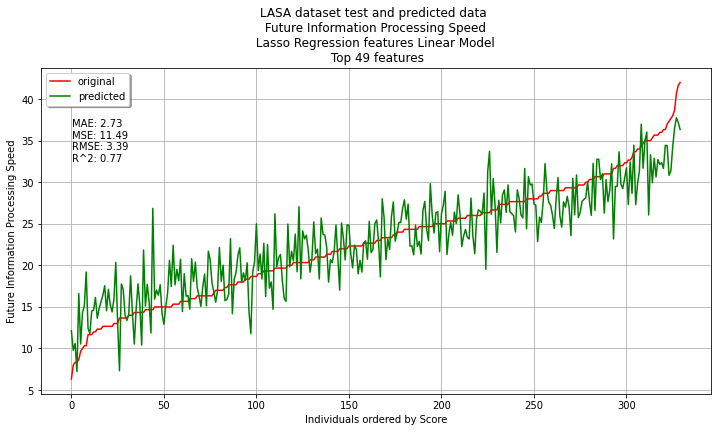

In [56]:
lasso_full_df_lm = pd.DataFrame(data = target, columns = ['target'])
lasso_full_df_lm['predicted'] = lm_pred_lasso
lasso_full_df = lasso_full_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, lasso_full_df.target, label="original", color = "red")
plt.plot(x_ax, lasso_full_df.predicted, label="predicted", color = "green")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Lasso Regression features Linear Model \n Top 49 features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 32.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)) + '\nR^2: ' + str(round(score,2)), fontsize = 10)
plt.show()

In [57]:
lm_lasso_nc = LinearRegression()
lm_lasso_nc.fit(df_train_nc[Lasso_importance_nc.features[0:ncog_features_n]], y_train)   
lm_pred_lasso_nc = lm_lasso_nc.predict(df_nc[Lasso_importance_nc.features[0:ncog_features_n]])

In [58]:
# accuracy check
mse = mean_squared_error(target, lm_pred_lasso_nc)
rmse = mse**(0.5)
mae = mean_absolute_error(target, lm_pred_lasso_nc)
score = r2_score(target, lm_pred_lasso_nc)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R^2: %.2f" % score)

MAE: 4.74
MSE: 35.19
RMSE: 5.93
R^2: 0.29


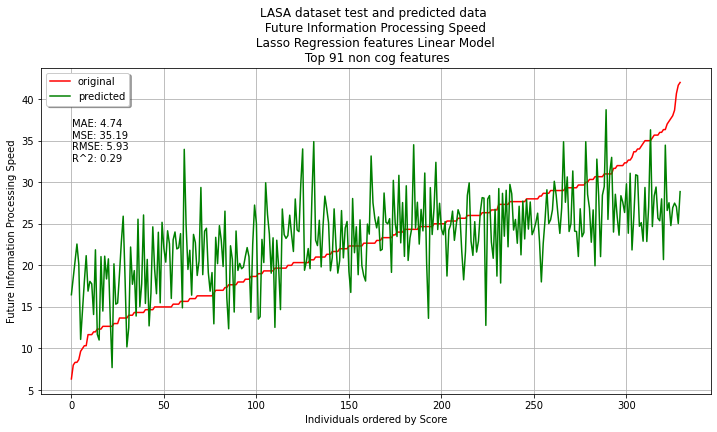

In [59]:
lasso_nc_df_lm = pd.DataFrame(data = target, columns = ['target'])
lasso_nc_df_lm['predicted'] = lm_pred_lasso_nc
lasso_nc_df_lm = lasso_nc_df_lm.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, lasso_nc_df_lm.target, label="original", color = "red")
plt.plot(x_ax, lasso_nc_df_lm.predicted, label="predicted", color = "green")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Lasso Regression features Linear Model \n Top 91 non cog features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 32.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)) + '\nR^2: ' + str(round(score,2)), fontsize = 10)
plt.show()

#### Ridge Regression

In [60]:
lm_ridge_full = LinearRegression()
lm_ridge_full.fit(df_train[Ridge_importance.features[0:all_features_n]], y_train)   
lm_pred_ridge = lm_ridge_full.predict(df[Ridge_importance.features[0:all_features_n]])

In [61]:
# accuracy check
mse = mean_squared_error(target, lm_pred_ridge)
rmse = mse**(0.5)
mae = mean_absolute_error(target, lm_pred_ridge)
score = r2_score(target, lm_pred_ridge)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R^2: %.2f" % score)

MAE: 2.66
MSE: 11.41
RMSE: 3.38
R^2: 0.77


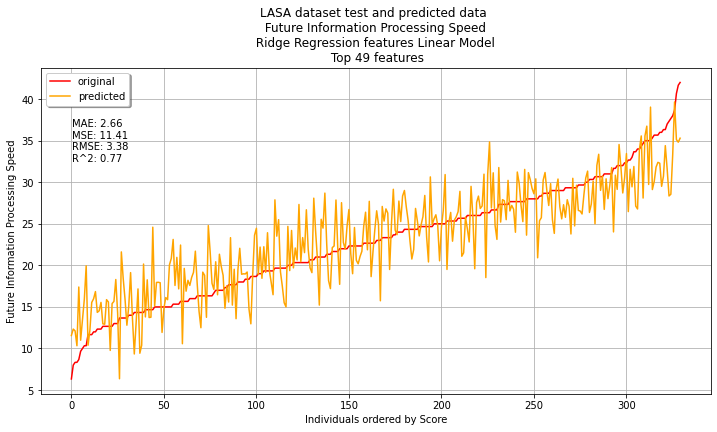

In [62]:
ridge_full_df_lm = pd.DataFrame(data = target, columns = ['target'])
ridge_full_df_lm['predicted'] = lm_pred_ridge
ridge_full_df = ridge_full_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, ridge_full_df.target, label="original", color = "red")
plt.plot(x_ax, ridge_full_df.predicted, label="predicted", color = "orange")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Ridge Regression features Linear Model \n Top 49 features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 32.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)) + '\nR^2: ' + str(round(score,2)), fontsize = 10)
plt.show()

In [63]:
lm_ridge_nc = LinearRegression()
lm_ridge_nc.fit(df_train_nc[Ridge_importance_nc.features[0:ncog_features_n]], y_train)   
lm_pred_ridge_nc = lm_ridge_nc.predict(df_nc[Ridge_importance_nc.features[0:ncog_features_n]])

In [64]:
# accuracy check
mse = mean_squared_error(target, lm_pred_ridge_nc)
rmse = mse**(0.5)
mae = mean_absolute_error(target, lm_pred_ridge_nc)
score = r2_score(target, lm_pred_ridge_nc)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R^2: %.2f" % score)

MAE: 4.60
MSE: 34.50
RMSE: 5.87
R^2: 0.30


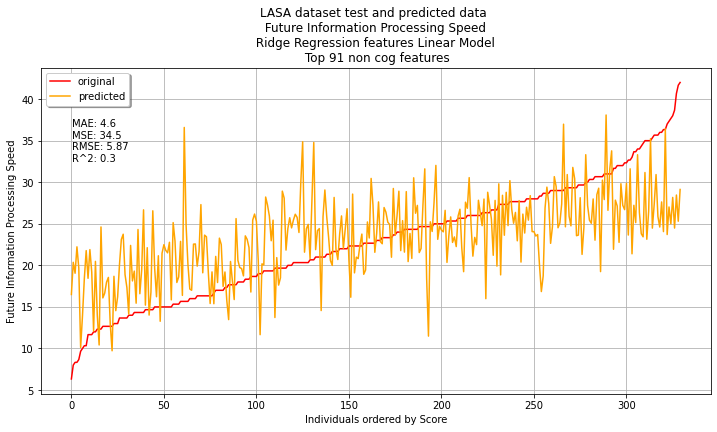

In [65]:
ridge_nc_df_lm = pd.DataFrame(data = target, columns = ['target'])
ridge_nc_df_lm['predicted'] = lm_pred_ridge_nc
ridge_nc_df_lm = ridge_nc_df_lm.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, ridge_nc_df_lm.target, label="original", color = "red")
plt.plot(x_ax, ridge_nc_df_lm.predicted, label="predicted", color = "orange")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Ridge Regression features Linear Model \n Top 91 non cog features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 32.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)) + '\nR^2: ' + str(round(score,2)), fontsize = 10)
plt.show()

#### SVM

In [66]:
lm_svm_full = LinearRegression()
lm_svm_full.fit(df_train[SVM_importance.features[0:all_features_n]], y_train)   
lm_pred_svm = lm_svm_full.predict(df[SVM_importance.features[0:all_features_n]])

In [67]:
# accuracy check
mse = mean_squared_error(target, lm_pred_svm)
rmse = mse**(0.5)
mae = mean_absolute_error(target, lm_pred_svm)
score = r2_score(target, lm_pred_svm)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R^2: %.2f" % score)

MAE: 2.66
MSE: 11.00
RMSE: 3.32
R^2: 0.78


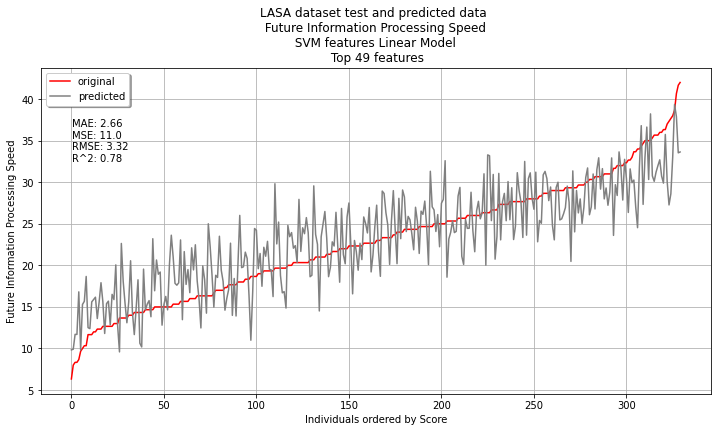

In [68]:
svm_full_df_lm = pd.DataFrame(data = target, columns = ['target'])
svm_full_df_lm['predicted'] = lm_pred_svm
svm_full_df = svm_full_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, svm_full_df.target, label="original", color = "red")
plt.plot(x_ax, svm_full_df.predicted, label="predicted", color = "grey")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n SVM features Linear Model \n Top 49 features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 32.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)) + '\nR^2: ' + str(round(score,2)), fontsize = 10)
plt.show()

In [69]:
lm_svm_nc = LinearRegression()
lm_svm_nc.fit(df_train_nc[SVM_importance_nc.features[0:ncog_features_n]], y_train)   
lm_pred_svm_nc = lm_svm_nc.predict(df_nc[SVM_importance_nc.features[0:ncog_features_n]])

In [70]:
# accuracy check
mse = mean_squared_error(target, lm_pred_svm_nc)
rmse = mse**(0.5)
mae = mean_absolute_error(target, lm_pred_svm_nc)
score = r2_score(target, lm_pred_svm_nc)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R^2: %.2f" % score)

MAE: 4.80
MSE: 35.40
RMSE: 5.95
R^2: 0.28


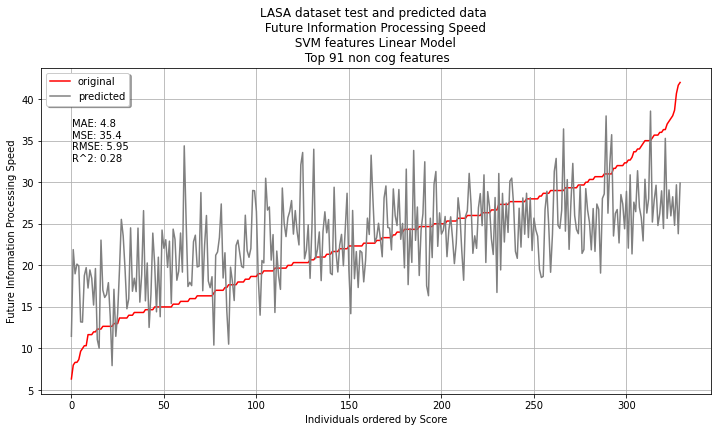

In [71]:
svm_nc_df_lm = pd.DataFrame(data = target, columns = ['target'])
svm_nc_df_lm['predicted'] = lm_pred_svm_nc
svm_nc_df_lm = svm_nc_df_lm.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, svm_nc_df_lm.target, label="original", color = "red")
plt.plot(x_ax, svm_nc_df_lm.predicted, label="predicted", color = "grey")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n SVM features Linear Model \n Top 91 non cog features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 32.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)) + '\nR^2: ' + str(round(score,2)), fontsize = 10)
plt.show()

## Baseline Linear Model

In [72]:
# Keep features from PhD student:
baseline_features = ['bme4','sex','primary_educat','intermediate_voc','higher_educat','bmsmokeyn','bno_alc_use','bmoderate_alc_use',
                     'bqphseff','bcesdint','bnormal_sleep','bhigh_sleep','Bnwdiversity','bbmi','bsystolic_pressure','b_DM','bhart05']

In [73]:
lm_baseline = LinearRegression()
lm_baseline.fit(df_train[baseline_features], y_train)   
baseline_pred = lm_baseline.predict(df[baseline_features])

In [74]:
# accuracy check
mse = mean_squared_error(target, baseline_pred)
rmse = mse**(0.5)
mae = mean_absolute_error(target, baseline_pred)
score = r2_score(target, baseline_pred)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R^2: %.2f" % score)

MAE: 5.35
MSE: 43.05
RMSE: 6.56
R^2: 0.13


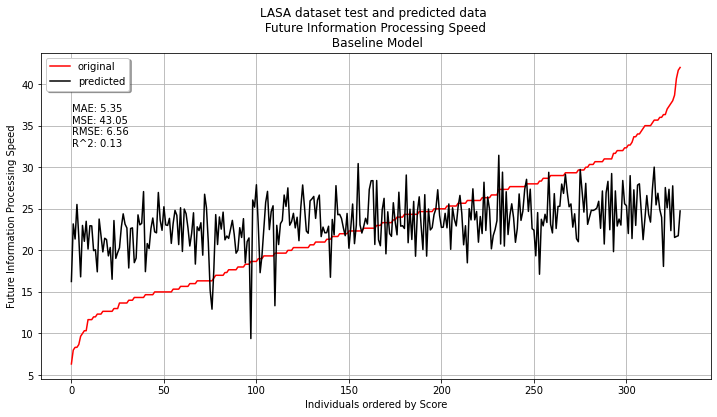

In [75]:
baseline = pd.DataFrame(data = target, columns = ['target'])
baseline['predicted'] = baseline_pred
baseline = baseline.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, baseline.target, label="original", color = "red")
plt.plot(x_ax, baseline.predicted, label="predicted", color = "black")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Baseline Model")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 32.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)) + '\nR^2: ' + str(round(score,2)), fontsize = 10)
plt.show()